In [120]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [121]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

In [ ]:
# BROADCASTING = a technique to use arrays & tensors expressively
# SGD = Stochastic Gradient Descent, the mechnaism for learning by updating weights automatically :-D


## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [3]:
# MNIST is a dataset in computer vision, it contains images of handwriten digits.
# Here we're making a model that can tell if a digit is a 3 OR 7
    # the 3 & 7 images are in MNIST_SAMPLE

path = untar_data(URLs.MNIST_SAMPLE)

In [24]:
#hide
Path.BASE_PATH = path
print(path)
print(type(path))

# can also do stuff like...
# path.ls??  # for source code
doc(path)    # for docs


/home/jupyter/.fastai/data/mnist_sample
<class 'pathlib.PosixPath'>


fastai/data/mnist_sample [source] Path subclass for non-Windows systems. 
 On a POSIX system, instantiating a Path should return this object.

In [5]:
# see there are 3 folders under this path
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [6]:
# and 2 folders under train/
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
# Use Image class from PIL/PythonImagingLibrary to show a file under a path

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
# To see the numbers that make up this image,
# ... we need to convert it to a NumPy array
# array(openedImage)[rowRange, colRange], where range format is inc:exc
    # the example below gives rows from index4 to index9, and columns from 4-9.  
    # With row/column 0/0 being the top left hand corner.

array(im3)[4:10,4:10]
    # dtype says they're 8bit unsigned int

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
# ... Or convert it to a PyTorch tensor
    # basically a Pytorch version of a NumPy array, behaviors almost identically
    # !!! the diff is PyTorch tensor can be computed on GPU, and has more functionalities
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [17]:
# change them back to color... 0=white, 255=black
# using a Panda DataFrame

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:10,4:10])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0,0,29
2,0,0,0,48,166,224
3,0,93,244,249,253,187
4,0,107,253,253,230,48
5,0,3,20,20,15,0


In [16]:

im3_tBigger = tensor(im3)
dfBigger = pd.DataFrame(im3_tBigger[4:15,4:22])
dfBigger.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [ ]:
So, here is a first idea: 
    how about we find the average pixel value for every pixel of the 3s, 
    then do the same for the 7s. 
This will give us two group averages, defining what we might call the "ideal" 3 and 7. 
Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. 
This certainly seems like it should be better than nothing, so it will make a good baseline.

Baseline === A simple model which you are confident should perform reasonably well. 
    It should be very simple to implement, 
    and very easy to test, so that you can then test each of your improved ideas, 
    and make sure they are always better than your baseline. 
Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. 

One good approach to creating a baseline is doing what we have done here: 
    think of a simple, easy-to-implement model. 
Another good approach is to find other people that have solved similar problems to yours, 
    and download and run their code on your dataset. 

Ideally, try both of these!

In [27]:
# tensor(imageObj) to translate into tensors!
seven_tensors = [tensor(Image.open(img)) for img in sevens]
three_tensors = [tensor(Image.open(img)) for img in threes]
print(f"{len(three_tensors)} images of 3 are now tensors,\n{len(seven_tensors)} images of 7 are now tensors")
print("check out one right now!")
three_tensors[1]

6131 images of 3 are now tensors,
6265 images of 7 are now tensors
check out one right now!


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 2

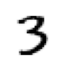

In [26]:
# show_image(tensorObj) to translate back into image!

show_image(three_tensors[1]);

In [28]:
# Now we want to stack all these numbers on top of each other, and later we'll average it
    # ok... that's why we want tensors to have the same size

# Here we're STACKING allt he imgs into a single 3D tensor, aka "rank-3 tensor"    
    # Since we'll be doing math on it later, let's cast it to float()
    # we want float pixel values to be between 0 and 1, so we need to divide the color by 255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# the SHAPE tells u the length of each axis, 
    # this tells us we have 6131 images, each of size 28x28pixels
stacked_threes.shape

torch.Size([6131, 28, 28])

In [34]:
# the RANK is the length of a tensor's SHAPE.   
    # remember earlier, we're stacking all our images into a 3D tensor, aka rank-3 tensor
print(f"RANK = {len(stacked_threes.shape)}  \t<-- via len(tensorObj.shape)")
print(f"RANK = {stacked_threes.ndim}  \t<-- via tensorObj.ndim")

RANK = 3  	<-- via len(tensorObj.shape)
RANK = 3  	<-- via tensorObj.ndim


In [ ]:
!!! DIMENSION is sometimes used in 2 ways
    size of an AXIS
    size of a RANK (or, number of AXES)
Best to just use Rank & Axis & Length instead of DIMENSION

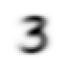

In [35]:
# Let's look at the IDEAL 3!
mean3 = stacked_threes.mean(0)
show_image(mean3);

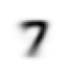

In [36]:
# Look at the IDEAL 7!
mean7 = stacked_sevens.mean(0)
show_image(mean7);

In [ ]:
!!! waaaait... but if someone rotates a test data, then this would not work...

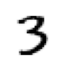

In [37]:
### Now we want to see how one of our training piece measures up against this AVERAGE/IDEAL 3   
    # we want to measure its DISTANCE from our ideal

# take a random 3
a_3 = stacked_threes[1]
show_image(a_3);

In [40]:
# print(a_3)  <- will print a giant tensor of numberes
# print()
# print(mean3)


dist_3_abs = (a_3 - mean3).abs().mean()
    # using abs() to so +/-'s don't wash each other out
    # MEAN ABSOLUTE DIFFERENCE, aka L1 NORM
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
    # ROOT MEAN SQUARED ERROR (RMSE), aka L2 NORM
    
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [41]:
# ok, how does our random 3 measure against the ideal/mean 7?
    # yesssss... this one is farther away, so we're more sure our random 3 is a 3 than we are it's a 7

dist_7_abs = (a_3 - mean7).abs().mean()
    # MEAN ABSOLUTE DIFFERENCE, aka L1 NORM
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
    # ROOT MEAN SQUARED ERROR (RMSE), aka L2 NORM
    
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [44]:
# LOSS FUNCTIONS
    # via torch.nn.functional, which is commonly imported as F
    
# rewriting the dist_3_abs & dist_3_sqr above...
print(F.l1_loss(a_3.float(), mean3))
print(F.mse_loss(a_3, mean3).sqrt())

# rewriting the dist_7_abs & dist_7_sqr above...
print(F.l1_loss(a_3.float(),mean7))
print(F.mse_loss(a_3,mean7).sqrt())

tensor(0.1114)
tensor(0.2021)
tensor(0.1586)
tensor(0.3021)


In [ ]:
MEAN ABSOLUTE DIFFERENCE (L1 NORM) vs ROOT MEAN SQUARED ERROR (RMSE)(L2 NORM)
    L2 NORM is supposed to penalize bigger mistakes more heavily,
    but more lenient with small mistakes

L1_NORM = (tensor1 - tensor2).abs().mean()
L2_NORM = [(tensor1 - tensor2)**2].mean().sqrt()

### NumPy Arrays and PyTorch Tensors

In [ ]:
# WHY NumPy arrays or PyTorch tensors? 
#     computes way faster bc they're in C

# PyTorch tensors cannot be jagged, it's always a regular shaped multidimensional rect structure.
# PyTorch tensors also can't use just any type, it has to be a single basic numeric type for all comps.

    

In [45]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [46]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [47]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [48]:
tns[1]

tensor([4, 5, 6])

In [49]:
tns[:,1]

tensor([2, 5])

In [50]:
tns[1,1:3]

tensor([5, 6])

In [51]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [52]:
tns.type()

'torch.LongTensor'

In [53]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [ ]:
L1_NORM & L2_NORM above are great and all, but not very understandable.
    ^ These loss fcns describe how well the model works with our TRAINING SET
So we normally use ACCURACY as the metric for classification models.

This metric is calc'd over a VALIDATION SET.

So now we'll grab the validation set from the valid/ folder

In [54]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255


# check shapes as u go.  Here we see we have a 3-rank tensor, with 3 axes of 1000+ images, 28 pixels x 28 pixels
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [55]:
# calc the mean absolute error thusly:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
    # what is this (-1, -2) in mean above???
        # it's a range of axes. Last & 2nd-to-last element, basically the pixels.
        # we averaged the intensity of all the pixels in an image.
    # this is meant to be somewhat similar to how we wrote L1_NORM above
mnist_distance(a_3, mean3)

tensor(0.1114)

In [63]:
# To calc a metric for overall ACCURACY, we need the distance to ideal 3 for EVERY image in the VALIDATION SET
# but we don't need to loop it, just pass in the entire tensor set
    # huh... it actually didn't throw an error
    # PyTorch magic in (a-b),
        # When it tries to subtract between 2 tensors of diff RANKS, will use BROADCASTING!!!
        # It AUTO EXPANDS the tensor w/ the samller rank to the same size as the one with the larger rank!!!
        # So this BROADCASTING happens to mean3 when it's up against valid_3_tens!!!
            # Basically, it's like there's 1000+ ideal images to subtract against each tensor in valid_3_tens!!!
        
print("single tensor a_3 vs full set valid_3_tens")
print(f"\tRANK = {len(a_3.shape)} <-- tensor of single image with 28x28 pixels")
print(f"\tRANK = {len(valid_3_tens.shape)} <-- 3D (rank3) tensor with 1000+imgs of 28x28 pixels")
print(f"\tRANK of mean3 = {len(mean3.shape)} <-- tensor of single IDEAL image with 28x28 pixels")

valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

single tensor a_3 vs full set valid_3_tens
	RANK = 2 <-- tensor of single image with 28x28pixels
	RANK = 3 <-- 3D (rank3) tensor with 1000+imgs of 28x28 pixels
	RANK of mean3 = 2


(tensor([0.1202, 0.1417, 0.1763,  ..., 0.1292, 0.1318, 0.1603]),
 torch.Size([1010]))

In [64]:
# oh snap!  BROADCASTING turns the 2nd element into [1,1,1]
tensor([1,2,3]) + tensor(1)


tensor([2, 3, 4])

In [68]:
print(valid_3_tens.shape)
print(mean3.shape)

# We are calculating the difference between our "ideal 3" and each of the 1000+  in the validation set, 
    # for each of 28×28 images, resulting in the shape [1010,28,28].
(valid_3_tens-mean3).shape

### PyTorch doesn't ACTUALLY copy mean3 1000x, it just pretends it were a tensor of that shape.
# It does the whole calc in C (or in CUDA if you're using a GPU), which up to 1Mx faster.

torch.Size([1010, 28, 28])
torch.Size([28, 28])


torch.Size([1010, 28, 28])

In [69]:
### THIS IS THE PREDICTION!!!! X is 3 if it's closer to mean3 than it is to mean7
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [70]:
# Prediction just a_3 taken from our training set
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [71]:
# Prediction on the entire validation set
is_3(valid_3_tens)

tensor([ True,  True,  True,  ...,  True,  True, False])

In [72]:
# Now we can calculate the accuracy for each of the 3s and 7s 
# by taking the average of that function for all 3s and its inverse for all 7s:

accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

In [ ]:
Now use GSD to auto figure out the best weights for our model!
... but HOW?!

Instead of trying to find the similarity between an image and an "ideal image," 
we could instead look at each individual pixel 
and come up with a set of weights for each one, 
such that the highest weights are associated with those pixels most likely to be black for a particular category

For instance, pixels toward the bottom right 
    are not very likely to be activated for a 7, so they should have a low weight for a 7, 
    but they are likely to be activated for an 8, so they should have a high weight for an 8. 
    
    
########## STEPS: ##########
    1. Initialize the weights
            usu random
    2. For each img, use these weights to PREDICT whether it's a 3 or 7
    3. Based on these predictions, calc LOSS (how good the model is)
            loss fcn returns small number if model is good, large number if bad
    4. Calc he GRADIENT, which measures for each weight, how changing that weight can change loss
    5. STEP (change) all the weights based on that calc
            incr or decr a bit, in the direction of low loss.
            can be slow if we do baby steps, but with GRADIENT calc we can take bigger steps.
    6. Go back to step 2, repeat.
    7. Iter til u stop the training process (once it's good enough or used up all epochs)

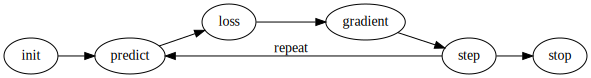

In [73]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [74]:
def f(x): return x**2

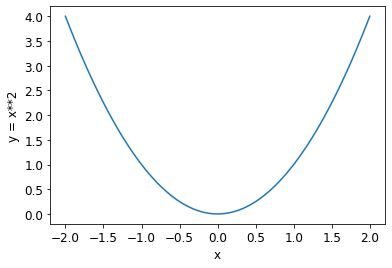

In [76]:
plot_function(f, 'x', 'y = x**2')

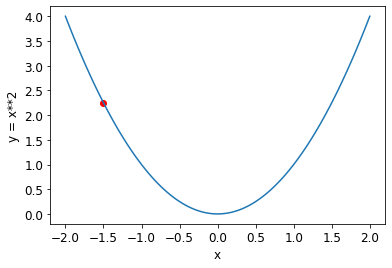

In [77]:
plot_function(f, 'x', 'y = x**2')
plt.scatter(-1.5, f(-1.5), color='red');

In [ ]:
If we +/- our param by a bit (the ADJUSTMENT), this is the slope at a particular point.
We can get to the lowest point of the curve by chg the x/weight, and see what y/result we get.
Based on the slope (loss), adjust how much to change x/weight next time.
Do this until we eventually get to the lowest point on the curve
    [0,0] where the slope=0 loss is minimum, yay

The further away from [0,0] we are, the steeper the slope, so the more we need to change x/weight
    Starting at the randomized red dot where the init weight is -1.5
    I guess this is what happesn....
        We want a flatter slope, so pretend we decr x to -2.5
        That gives us a worse/steeper slope/loss, so we incr x instead, to -0.5
        That gives us a nice flater slope, can we do better?
        Try incr to 0.5
        Slope is same, but diff direction, so double back to x=0
        yay, foudn it.
    But... how do we know how much to adjust? See "STEPPING WITH LEARNING RATE" below
    
Calculus derivatives tells us how fast the slope changes: 
    slope = (y2-y1)/(x2-x1)
    
Our actual fcn has LOTS Of adjustable weights, 
    so we will get back LOTS of derivatives, 1 for each weight.


### Calculating Gradients

In [81]:
# PyTorch will calc derivs for us, yay
    # .requires_grad() says we want to calc gradients wrt that weight variable at that value.

xt = tensor(3.).requires_grad_()

In [82]:
# Now we calculate our function with that value. 
    # Notice how PyTorch prints not just the value calculated, 
    # but also a note that it has a gradient function it'll be using to calculate our gradients when needed
yt = f(xt)
    # remember earlier we defined f(arg1) to return arg1**2
    # so here we are telling it to pass in tensor(3) to be squared
yt

tensor(9., grad_fn=<PowBackward0>)

In [83]:
# functionValue.backward() tells it to CALC GRADIENTS for us
    # BACKPROPAGATION, name given to the process of calc deriv of each layer
    # aka "backward pass" of the network, vs "forward pass" where the activations are calc'd
    # ^ what?!

yt.backward()

In [84]:
# paramTensor.grad to view gradients
    # y = x^2 has derivative of 2x, therefore since we passed in tensor(3), we get deriv of tensor(6)
xt.grad

tensor(6.)

In [85]:
# now try a bigger tensor as the x/weight/params

xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [86]:
# with a diff fcn

def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [87]:
# valueFromFcn.backward() to CALC GRADIENT/derivative        # slope is still 2x
# params.grad to show it
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

In [ ]:
Basically multiply the gradient by some small number called LEARNING RATE (LR)
    LR is usu between 0.001 and 0.1
    Ppl try a few diff LRs to see which gives the best model (also covered in LEARNING RATE FINDER later)

LRs that are too low are baby steps, and training can take forever
LRs that are too high is worse, causes doubling back on directions due to overshoot.
See pictures in non-clean version, but its' pretty dang obvious from the parabola graph above in cell 78.
    

### An End-to-End SGD Example

In [139]:
# pretend these are the speeds measured of a roller coaster q20sec
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

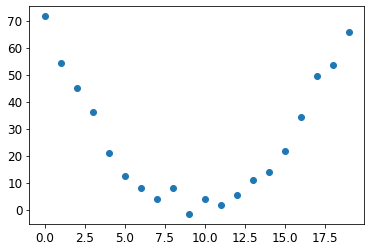

In [140]:
# ignore this line below, it's just generating ~random graph points
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [141]:
# f() is our PREDICTION, for describing what the real blue speed data we see above
# a/b/c are params that corresp to what kind of quadratic shape we're trying.  
    # a for quadratic, b for linear, c for constant
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [142]:
# we need to define first what we mean by "best"
### so we use a LOSS FCN here.  
    # lower = better
    # SGD will adjust weights towards lower LOSS FCN values, to minimize loss.
    # For continuous data, it's common to use MEAN SQUARED ERROR

def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

#### Step 1: Initialize the parameters

In [143]:
# remmeber to take on .requires_grad() to tag it for GRADIENT calc!
params = torch.randn(3).requires_grad_()
print(f"Our first randomized params {params}")

Our first randomized params tensor([ 0.4000, -1.2039, -0.4198], requires_grad=True)


In [144]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [145]:
# Run our params through our prediction model f()
preds = f(time, params)

In [146]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

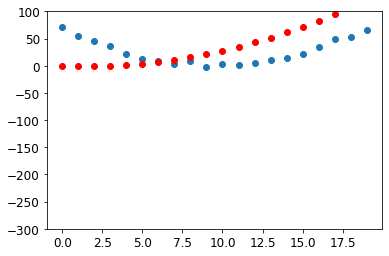

In [147]:
# red plot is my initial "prediction" using the randomized a/b/c params
# blue plot is the real-life speed data that I'm trying to approx w/ my model
show_preds(preds)

#### Step 3: Calculate the loss

In [148]:
# Look at the MSE of red-v-blue delta-Y for each x
loss = mse(preds, speed)
print(f"INITIAL TRIAL: loss = {loss}")

INITIAL TRIAL: loss = 40.331939697265625


#### Step 4: Calculate the gradients

In [149]:
### lossVal.backward() <-- TO CALC GRADIENT/deriv
### params.grad        <-- to GIVE results
loss.backward()
print("What is the slope/derivative? We want close to 0")
params.grad


What is the slope/derivative? We want close to 0


tensor([128.1733,   8.0188,   0.2868])

In [152]:
# FOR Step 5, we can ADJUST the weight! via LEARNING RATE
chgToNewParams = params.grad * 1e-5
chgToNewParams

tensor([1.2817e-03, 8.0188e-05, 2.8682e-06])

In [151]:
# we haven't actually changed the params yet
params

tensor([ 0.4000, -1.2039, -0.4198], requires_grad=True)

#### Step 5: Step the weights. 

In [156]:
# update the parameters based on the calc'd gradient
lr = 1e-5

# NOTE that we're decreasing params.DATA, not params itself
params.data -= lr * params.grad.data

# ALSO, now that params is updated ot new value, we need to wipe the gradient results in params.grad
params.grad = None

In [157]:
# what's the new prediction & resulting loss value?
preds = f(time,params)
loss = mse(preds, speed)
print(f"loss = {loss}  <-- is it lower this time?")

print("How does params.grad look? is the tensor a lower derivative now?")
loss.backward()
params.grad


# To calculate the gradients...
# we call backward on the loss value. 
  # But this loss was itself calculated by loss fcn of mse(), 
    # which took preds as an input, 
      # which was calc'd using starter prediction of f(), taking as an input params, 
        # which was the object on which we originally called .required_grads_ on, to track these weight/params
          # which is the original call that now allows us to call backward on loss value

loss = 39.84030532836914  <-- is it lower this time?
How does params.grad look? is the tensor a lower derivative now?


tensor([127.0341,   7.9431,   0.2784])

In [ ]:
##### The loss & params.grad should be lower this time, since we're making baby steps (0.00001)
# towards a lower slope.  
# Unless we went the wrong direction, idk how we decided on DECR instead of INCR

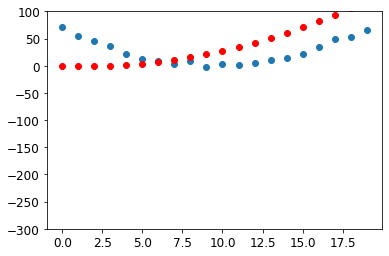

In [158]:
show_preds(preds)

In [165]:
# Since we need to repeat STEP 5 a bunch of times, we need this:
        # I added the 2nd param so I can adjust it myself
def apply_step(params, lr=1e-5, prn=True):
    # Make prediction w/ given params
    preds = f(time, params)
    # Calc loss fcn value from prediction
    loss = mse(preds, speed)
    # Calc GRADIENT on that loss fcn value
    loss.backward()
    # We could show params.grad and see how our slope/deriv is hopefully flatter now, but not gonna bother
    # Adjust per Learning Rate
    params.data -= lr * params.grad.data
    # Wipe params.grad for next gradient calc
    params.grad = None
    if prn: 
        print(loss.item())
        # show_preds(preds)  # graphs might not look all that diff from each other bc LR is so small
    return preds

#### Step 6: Repeat the process 

In [166]:
# see the loss is going down :-D
# THIS IS 10 EPOCHS
for i in range(10): apply_step(params)

38.72935104370117
38.574607849121094
38.420894622802734
38.268211364746094
38.1165657043457
37.965965270996094
37.816410064697266
37.667903900146484
37.52045822143555
37.37407684326172


In [167]:
#hide
params = orig_params.detach().requires_grad_()

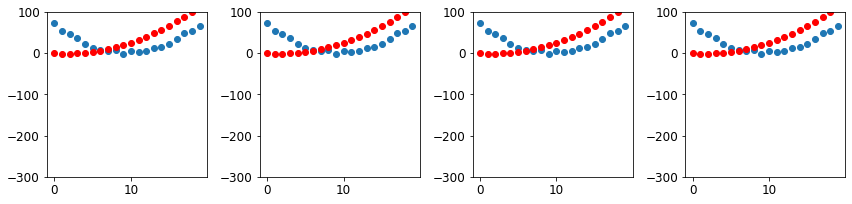

In [168]:
# ok, the loss is going down, let's also look at how prediction graphs changed through time
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [180]:
# What if I'm not happy yet and want 50 epochs??? with a more aggressive LR???

for i in range(50): apply_step(params, lr*1000)

26.02480125427246
26.0246524810791
26.024503707885742
26.02436065673828
26.024221420288086
26.02408218383789
26.023950576782227
26.023815155029297
26.023685455322266
26.023561477661133
26.023435592651367
26.0233154296875
26.023197174072266
26.023082733154297
26.022966384887695
26.022855758666992
26.022747039794922
26.022640228271484
26.02253532409668
26.02243423461914
26.02233123779297
26.022235870361328
26.022140502929688
26.02204704284668
26.021953582763672
26.02186393737793
26.021778106689453
26.021690368652344
26.021604537963867
26.021522521972656
26.021442413330078
26.021360397338867
26.021286010742188
26.021209716796875
26.021135330200195
26.021060943603516
26.0209903717041
26.020919799804688
26.020851135253906
26.020784378051758
26.020719528198242
26.02065658569336
26.020591735839844
26.020530700683594
26.020469665527344
26.020410537719727
26.02035140991211
26.020296096801758
26.020238876342773
26.020187377929688


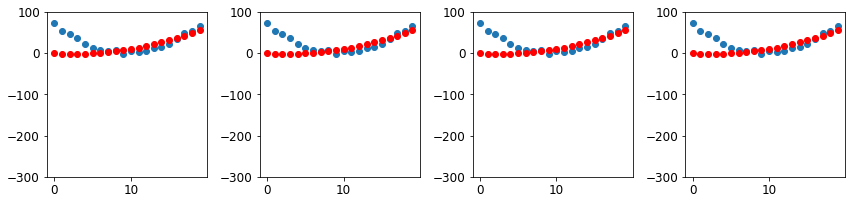

In [181]:
# Have I gotten even closer?!
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

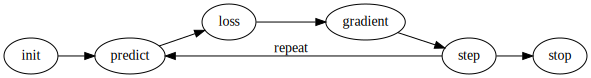

In [182]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [ ]:
!!!I STOPPED HERE!!!

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [ ]:
(train_x[0]*weights.T).sum() + bias

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

In [ ]:
corrects = (preds>0.5).float() == train_y
corrects

In [ ]:
corrects.float().mean().item()

In [ ]:
weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
torch.where(trgts==1, 1-prds, prds)

In [ ]:
mnist_loss(prds,trgts)

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

### Sigmoid

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

## Putting It All Together

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
batch = train_x[:4]
batch.shape

In [ ]:
preds = linear1(batch)
preds

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
(preds>0.0).float() == train_y[:4]

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

### Creating an Optimizer

In [ ]:
linear_model = nn.Linear(28*28,1)

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
validate_epoch(linear_model)

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(10, lr=lr)

## Adding a Nonlinearity

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [ ]:
plot_function(F.relu)

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
learn.recorder.values[-1][2]

### Going Deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.